# Numerische Methoden für Differentialgleichungen
## Aufgabenblatt 6
*gelöst von Stollmayer Max*

_Zu implementieren ist eine Finite-Differenzen-Methode für die Poisson-Gleichung (elliptische PDE):_

\begin{cases}
-\Delta u(x,y)=f(x,y), \ (x,y)\in\Omega \\
u(x,y)=v(x,y), \ (x,y)\in\partial\Omega
\end{cases}

#### Konstruktion

Wie für die 1-dimensionale Finite-Differenzen-Methode approximieren wir den Laplace-Operator über die zentralen Differenzen, aber nun in beide Richtungen, wobei $u_{i,j} \approx u(x_i, y_j)$ für $i,j=1,\dots,N-1:$

$$\Delta u(x_i,y_j) := \frac{\partial^2}{\partial x^2} u(x_i,y_j) + \frac{\partial^2}{\partial y^2} u(x_i,y_j) \approx \frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{h^2} + \frac{u_{i,j+1}-2u_{i,j}+u_{i,j-1}}{h^2} \\
\iff \frac{4u_{i,j}-u_{i-1,j}-u_{i+1,j}-u_{i,j-1}-u_{i,j+1}}{h^2} = f(x_i,y_j)$$

Damit erhalten wir wieder ein Gleichungssystem $-L \ U = F$ mit $U = (u_{i,j})_{i,j=1}^{N-1}$ und $F = \big(f(x_i,y_j)\big)_{i,j=1}^{N-1}$ als Vektoren der Länge $(N-1)^2$ aufgeffast und der $(N-1)^2 \times (N-1)^2$-Matrix

$$L = \frac{1}{h^2}
\begin{pmatrix}
    T & -I & 0 & \cdots & 0 \\
    -I & T & -I & \ddots & \vdots \\
    0 & -I & \ddots & \ddots & 0 \\
    \vdots & \ddots & \ddots & \ddots & -I \\
    0 & \cdots & 0 & -I & T
\end{pmatrix}$$

mit der $(N-1) \times (N-1)$-Einheitsmatrix $I$ und den $(N-1) \times (N-1)$-Blöcken

$$T = 
\begin{pmatrix}
    4 & -1 & 0 & \cdots & 0 \\
    -1 & 4 & -1 & \ddots & \vdots \\
    0 & -1 & \ddots & \ddots & 0 \\
    \vdots & \ddots & \ddots & \ddots & -1 \\
    0 & \cdots & 0 & -1 & 4
\end{pmatrix}$$

Da in jeder Zeile nur maximal 5 Nicht-Null-Einträge vorkommen, lassen sich effiziente iterative Verfahren anwenden.

#### Konvergenz

Analog zur Rechnung mit der Taylorentwicklung erhält man die Konvergenzordnung 2. Außerdem ist die Matrix L positiv definit und stabil, was man mit einer Eigenwertbestimmung zeigt. Damit ist diese Finite-Differenzen-Methode konvergent mit Ordnung 2.

#### Implementierung

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcdefaults()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", figsize=(11.2, 6.3))
plt.rc("font", size=12)
plt.rc("axes", edgecolor="white")
plt.rc("legend", frameon=True, framealpha=0.8, facecolor="white", edgecolor="white")

In [2]:
def solvePoisson(f, g, a, b, N):
    '''
    Solves -Laplace[u(x,y)] = f(x,y) with the boundary condition u(x,y) = g(x,y)
    on an equidistantly discretized square [a,b] x [a,b].
    
    Returns array of function values on the grid.
    
    f ... inhomogeneity function
    g ... boundary condition function
    a ... (a, a) is lower left corner of the square
    b ... (b, b) is upper right corner of the square
    N ... number of discretization steps
    '''
    
    h = (b - a) / N
    axis = np.linspace(a, b, N+1)
    
    # generate f values on the inner grid
    y = f(axis[1:-1, None], axis[None, 1:-1])
    
    # generate boundary values
    g_bot = g(axis, a)
    g_top = g(axis, b)
    g_l = g(a, axis)
    g_r = g(b, axis)
    
    # add boundary values to sides
    y[0] += g_bot[1:-1] / h**2
    y[-1] += g_top[1:-1] / h**2
    y[:, 0] += g_l[1:-1] / h**2
    y[:, -1] += g_r[1:-1] / h**2
    
    # system matrix generation
    M = (N-1)**2
    I1 = -sp.eye(M, M, N-1)
    I2 = -sp.eye(M, M, 1-N)
    T = -sp.eye(N-1, N-1, -1) + 4*sp.eye(N-1, N-1) - sp.eye(N-1, N-1, 1)
    A = sp.block_diag((N-1)*(T,))
    L = (I1 + A + I2) / h**2
    
    # add solution of the system to output array
    u = np.zeros((N+1, N+1))
    u[1:N, 1:N] = spsolve(L, y.flatten()).reshape((N-1, N-1))
    
    # add back boundary conditions
    u[0] = g_bot
    u[-1] = g_top
    u[:, 0] = g_l
    u[:, -1] = g_r
    
    return u

#### Test

Nun testen wir das Verfahren für $\Omega=[0,1]\times[0,1],$ $f(x,y)=sin(x y) \ (x^2+y^2)$ und $v(x,y)=sin(x y).$ Dazu berechnen wir den maximalen Fehler zur exakten Lösung $v$ für mehrere Schrittweiten und betrachten die Konvergenzordnung.

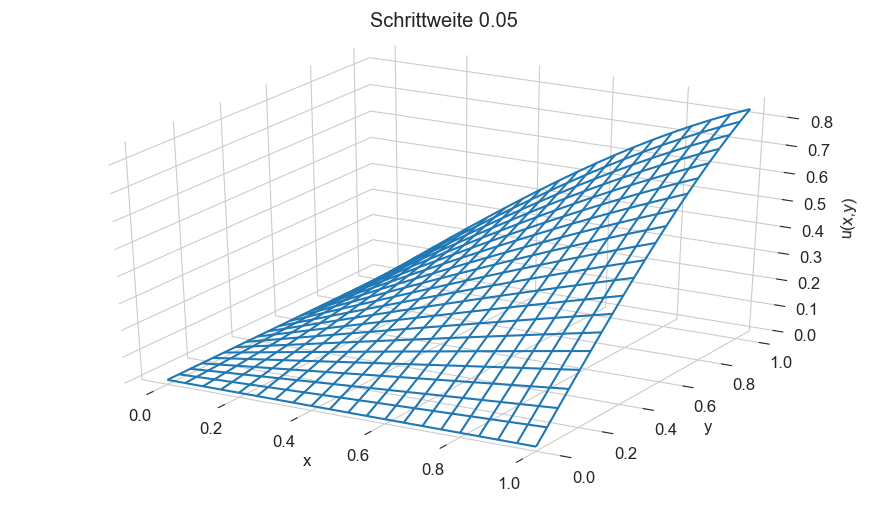

In [3]:
def f(x,y):
    return np.sin(x*y) * (x**2 + y**2)

def v(x,y):
    return np.sin(x*y)

a = 0
b = 1

N = 20
h = 1/N
x, y = np.mgrid[0:1+h:h, 0:1+h:h]
u = solvePoisson(f, v, a, b, N)

fig = plt.figure()
ax = fig.gca(projection="3d")

ax.w_xaxis.pane.set_color("w")
ax.w_yaxis.pane.set_color("w")
ax.w_zaxis.pane.set_color("w")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x,y)")
ax.set_title(f"Schrittweite {1/N}", pad=16)

ax.plot_wireframe(x, y, u)
plt.show()

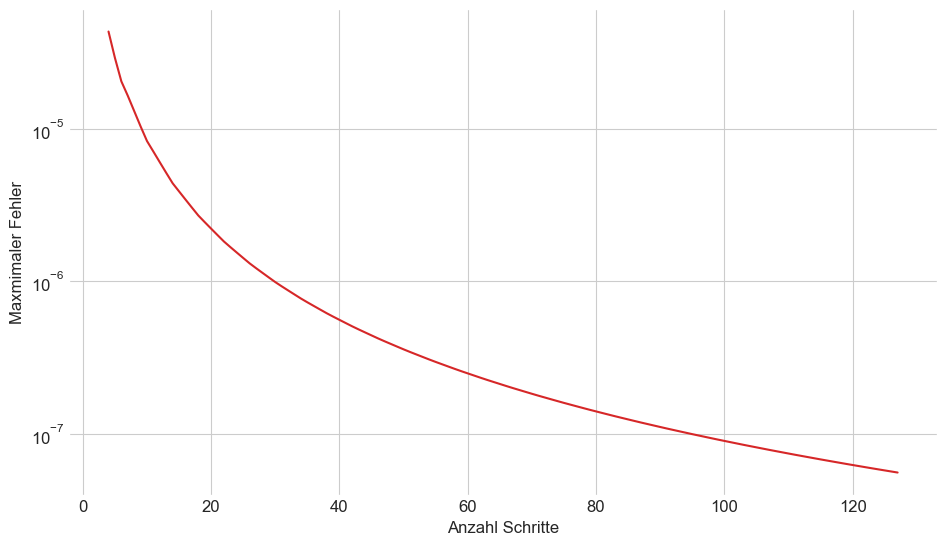

Approximierte Konvergenzordnung: 1.93


In [4]:
def error(n):
    '''Maximum norm'''
    u = solvePoisson(f, v, a, b, n)
    axis = np.linspace(a, b, n+1)
    exact = v(axis[:, None], axis[None, :])
    return max(np.abs(exact - u).flatten())

steps = np.arange(4, 128)
errors = [error(n) for n in steps]

plt.plot(steps, errors, color="C3")
plt.yscale("log")
plt.xlabel("Anzahl Schritte")
plt.ylabel("Maxmimaler Fehler")
plt.show()

order = np.log(errors[-1] / errors[0]) / np.log(steps[0] / steps[-1])
print(f"Approximierte Konvergenzordnung: {order:.2f}")

#### Beobachtungen

Mit den vorhandenen Lösungsverfahren für dünn-besetzte Matrizen ist die Finite-Differenzen-Methode trotz großer Systemmatrix relativ schnell ausgeführt. Die Fehler nehmen ca. quadratisch ab, wie aus der analytischen Betrachtung zu erwarten war.